In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from textwrap import wrap
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.patheffects import withStroke
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import matplotlib.colors
from fractions import Fraction
from matplotlib.patches import Rectangle
import os

# Prices used for current food and fuel products

### Cost of current food products (excluding cheese)

Current food product prices (except for cheese) can be calculated based on FAOSTAT agricultural value data. The FAO gives pre-aggregated values for the total monetary value of individual agricultural products on a global scale at the farm-gate. The FAO also gives global production volumes for individual products. Diving total global value by total global production volumes gives the average price of individual products on a global level. These prices correspond to producer prices at the farm-gate and are the closest proxy value to production costs for current products. Data for cheese is not included in this dataset and so is calculated from other datasets.

In [2]:
# download full data from https://www.fao.org/faostat/en/#data/QCL; selecting the 'All Data Normalized' download option 
# this csv files contains national annual production quantities for all items in the FAOSTAT database for the years 1961-2022 
# contains special country groupings e.g. World group or EU27
# take care to only include these groups when needed
# data was accessed on 9th May 2024

faostat_production_quantities = pd.read_csv(
    'Production_Crops_Livestock_E_All_Data_(Normalized).csv', 
    encoding='latin-1', low_memory=False
)

In [3]:
# download full data from https://www.fao.org/faostat/en/#data/QV; selecting the 'All Data Normalized' download option  
# this csv files contains the agricultural value for each food product across most countries between 1961 to 2022
# contains aggregated food groups e.g. Total meat
# represents animal products in two different ways (indigenous and standard)
# take care to only include these groups when needed
# data was accessed on 9th May 2024

faostat_value_ag_full = pd.read_csv(
    'Value_of_Production_E_All_Data_(Normalized).csv', encoding='latin-1'
)

In [4]:
# using 2022-2013 as the years of interest (most recent 10 years of data available)
# select global values
# use current USD (year 2021)
value_ag_decade = faostat_value_ag_full[
    (faostat_value_ag_full['Element'] == 'Gross Production Value (current thousand US$)')
    & (faostat_value_ag_full['Area'] == 'World')
    & (faostat_value_ag_full['Year Code'].isin([2013+i for i in range(10)]))
].copy()

In [5]:
prod_quant_world_decade = faostat_production_quantities[
    (faostat_production_quantities['Element'] == 'Production')
    & (faostat_production_quantities['Area'] == 'World')
    & (faostat_production_quantities['Unit'] == 't')
    & (faostat_production_quantities['Year Code'].isin([2013+i for i in range(10)]))
].copy()

In [6]:
# livestock value of production is measured in terms of indigenous meat
# non-indigenous livestock products are therefore removed to avoid confusion 
# indigenous refers to meat from animals raised in a given country (without considering trade of animals)
# it should be fine to use the total value of indigenous meat and divide by total meat production to get an 
# average meat value globally
# care should be taken to divide national indigenous meat by national meat production quantities as production
# quantities may include meat from foreign origins

indigenous_items = value_ag_decade[value_ag_decade['Item'].str.contains('indigenous')]['Item']

non_indigenous_items = list(value_ag_decade[
    value_ag_decade['Item'].isin(indigenous_items.str.replace(' (indigenous)',''))
]['Item'])

# not all non-indigenous livestock products were captured above, so manually add those missing
non_indigenous_items.append('Meat of other domestic rodents, fresh or chilled')

# remove all non-indigenous livestock products to avoid confusion between the different products
value_ag_decade = value_ag_decade[~value_ag_decade['Item'].isin(non_indigenous_items)].copy()

# remove indigenous label to align with namings in other FAOSTAT production dataset 
value_ag_decade['Item'] = value_ag_decade['Item'].str.replace(' (indigenous)','')

In [7]:
# rename 'Value' to give different names to help when merging data into a single dataframe 
value_ag_decade.rename(
    columns={'Value':'total_value_usd'}, inplace=True
)
prod_quant_world_decade.rename(
    columns={'Value':'production_quantity_tonne'}, inplace=True
)

In [8]:
prod_quant_world_decade['align_on'] = prod_quant_world_decade.agg('{0[Item]}_{0[Year Code]}'.format, axis=1)
value_ag_decade['align_on'] = value_ag_decade.agg('{0[Item]}_{0[Year Code]}'.format, axis=1)

In [9]:
# combine production quantities (in tonnes/yr) and producer prices (in USD/tonne) into a single dataframe
# the data is merged on item name, year, and country
# only the union of the data is kept, much of the data is lost here as there is no counterpart 
product_prices_volumes = pd.merge(
    prod_quant_world_decade[['Item Code', 'Item', 'align_on', 'Year', 'production_quantity_tonne',]], 
    value_ag_decade[['align_on', 'total_value_usd']], 
    on="align_on")

# remove any prices that are 0 (just a quick check to make sure there are no issues)
product_prices_volumes = product_prices_volumes[
    (product_prices_volumes['total_value_usd'] > 0)
    & (product_prices_volumes['production_quantity_tonne'] > 0)
]

In [10]:
product_prices_volumes = product_prices_volumes.drop('align_on', axis=1)

In [11]:
# for each year, calculate the global producer price from total value and production quantities 
# and take the mean value across the ten year period
decade_average_usd_tonne = (
    product_prices_volumes.groupby('Item').
    apply(lambda x: 1000 * (x['total_value_usd']/x['production_quantity_tonne']).mean())
)

decade_average_usd_tonne.name = 'usd_per_tonne'

decade_average_usd_tonne.index.name = 'Item'

C:\Users\sammy\AppData\Local\Temp\ipykernel_10960\3651876658.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(lambda x: 1000 * (x['total_value_usd']/x['production_quantity_tonne']).mean())


In [12]:
# use decade mean production value as the characteristic value
avg_production_quant = (
    prod_quant_world_decade.groupby('Item')['production_quantity_tonne']
    .apply(lambda x: x.mean())
)

In [13]:
# combine production quantities (in tonnes/yr) 
# and agricultural value (in USD/tonne) into a single dataframe
# the data is merged on item name

total_production_value = pd.merge(
    avg_production_quant, 
    decade_average_usd_tonne, 
    on='Item'
)

In [14]:
total_production_value['production_quantity_kg'] = (
    total_production_value['production_quantity_tonne'] * 1e3
)
total_production_value['usd_per_kg'] = total_production_value['usd_per_tonne'] / 1000

In [15]:
total_production_value

production_quantity_tonne  \
Item                                                                            
Abaca, manila hemp, raw                                          1.071120e+05   
Agave fibres, raw, n.e.c.                                        4.072344e+04   
Almonds, in shell                                                3.309314e+06   
Anise, badian, coriander, cumin, caraway, fenne...               1.859475e+06   
Apples                                                           8.723921e+07   
...                                                                       ...   
Walnuts, in shell                                                3.144061e+06   
Watermelons                                                      1.006013e+08   
Wheat                                                            7.536759e+08   
Yams                                                             7.450158e+07   
Yautia                                                           4.523471e+05   

                                                    usd_per_tonne  \
Item                                                                
Abaca, manila hemp, raw                               1406.910589   
Agave fibres, raw, n.e.c.                              415.950608   
Almonds, in shell                                     4406.358673   
Anise, badian, coriander, cumin, caraway, fenne...    1302.374320   
Apples                                                 695.989145   
...                                                           ...   
Walnuts, in shell                                     4335.045400   
Watermelons                                            375.803036   
Wheat                                                  258.863705   
Yams                                                   356.171444   
Yautia                                                 345.110730   

                                                    production_quantity_kg  \
Item                                                                         
Abaca, manila hemp, raw                                       1.071120e+08   
Agave fibres, raw, n.e.c.                                     4.072344e+07   
Almonds, in shell                                             3.309314e+09   
Anise, badian, coriander, cumin, caraway, fenne...            1.859475e+09   
Apples                                                        8.723921e+10   
...                                                                    ...   
Walnuts, in shell                                             3.144061e+09   
Watermelons                                                   1.006013e+11   
Wheat                                                         7.536759e+11   
Yams                                                          7.450158e+10   
Yautia                                                        4.523471e+08   

                                                    usd_per_kg  
Item                                                            
Abaca, manila hemp, raw                               1.406911  
Agave fibres, raw, n.e.c.                             0.415951  
Almonds, in shell                                     4.406359  
Anise, badian, coriander, cumin, caraway, fenne...    1.302374  
Apples                                                0.695989  
...                                                        ...  
Walnuts, in shell                                     4.335045  
Watermelons                                           0.375803  
Wheat                                                 0.258864  
Yams                                                  0.356171  
Yautia                                                0.345111  

[191 rows x 4 columns]

In [16]:
total_production_value[
    total_production_value.index.isin([
        'Wheat', 'Rice', 'Maize (corn)',
        'Soya beans', 'Sugar cane', 'Cassava, fresh',
        'Potatoes', 'Meat of cattle with the bone, fresh or chilled',
        'Meat of sheep, fresh or chilled', 'Meat of pig with the bone, fresh or chilled',
        'Meat of chickens, fresh or chilled', 'Raw milk of cattle',
        'Hen eggs in shell, fresh',
    ])
]['usd_per_kg']

Item
Cassava, fresh                                    0.150217
Hen eggs in shell, fresh                          1.393362
Maize (corn)                                      0.236343
Meat of cattle with the bone, fresh or chilled    3.998505
Meat of chickens, fresh or chilled                1.946197
Meat of pig with the bone, fresh or chilled       2.490774
Meat of sheep, fresh or chilled                   4.887678
Potatoes                                          0.272440
Raw milk of cattle                                0.423315
Rice                                              0.429512
Soya beans                                        0.383214
Sugar cane                                        0.050062
Wheat                                             0.258864
Name: usd_per_kg, dtype: float64

### Cost of cheese

In the absence of producer price data for cheese, we used export price data as the second closest proxy to production cost values. The export prices are given as "free on board (f.o.b.) export prices", which refers to the cost of goods at the point of departure from the exporting country, excluding the costs of transportation, insurance, and other charges incurred after the goods leave the port of origin. Cheese export prices can be accessed from the FAO Food Price Monitoring and Analysis (FPMA) site.

In [17]:
# Import data for cheese from the FAO Food Price Monitoring and Analysis (FPMA) site
# Data can be accessed from this link https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international?permalink=23397429-69b2-472f-bfed-19d0bd943937
# Alternatively, go to https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international
# Select data for: Dairy: Cheddar Cheese (European & Oceania average indicative export prices, f.o.b)
# Data is in USD/tonne
# Download the full chart data as a csv and rename to 'cheese_fpma_prices.csv'
# Data used here was accessed on January 21st 2025
cheese_export_prices = pd.read_csv('cheese_fpma_prices.csv')
cheese_export_prices.columns = ['date', 'price_usd_per_tonne']

In [18]:
# change 'date' column into datetime format
cheese_export_prices['date'] = pd.to_datetime(cheese_export_prices['date'])

# using 2022-2013 as the years of interest
# inline with process used above
filtered_cheese_data = cheese_export_prices[
    (cheese_export_prices['date'] >= '2013-01-01') & 
    (cheese_export_prices['date'] <= '2022-12-31')
]

In [19]:
# 1000 kg per tonne
cheese_average_export_price_per_kg = filtered_cheese_data['price_usd_per_tonne'].mean() / 1000 

In [20]:
print(f'Cheese USD/kg: {round(cheese_average_export_price_per_kg, 1)}')

Cheese USD/kg: 3.8


### Cost of crude oil 
The cost of crude oil is taken from the World Bank Commodity prices, reflecting its international price over time. This serves as a proxy for production cost values.

In [21]:
# 'CMO-Historical-Data-Monthly.xlsx' contains the World Bank commodity prices (typically international prices) 
# of various commodities, including crude oil 
# Data can be accessed from: https://www.worldbank.org/en/research/commodity-markets
# Select the monthly price data for download

world_bank_commodity_prices = pd.read_excel('CMO-Historical-Data-Monthly.xlsx', sheet_name='Monthly Prices')

In [22]:
# format table
column_names = world_bank_commodity_prices.iloc[3] + ' ' + world_bank_commodity_prices.iloc[4]
world_bank_commodity_prices.columns = column_names
world_bank_commodity_prices = world_bank_commodity_prices.iloc[5:]
world_bank_commodity_prices = world_bank_commodity_prices.copy()
world_bank_commodity_prices.rename(columns={world_bank_commodity_prices.columns[0]: 'date'}, inplace=True)

In [23]:
# convert dates to date time format for pandas to enable filtering of years
dates = pd.to_datetime(world_bank_commodity_prices['date'], format='%YM%m')
world_bank_commodity_prices['date'] = dates

In [24]:
# using 2022-2013 as the years of interest
# inline with process used above
filtered_world_bank_commodity_prices = world_bank_commodity_prices[
    (world_bank_commodity_prices['date'] >= '2013-01-01') & 
    (world_bank_commodity_prices['date'] <= '2022-12-31')
]

In [25]:
average_crude_oil_price_usd_per_barrel = filtered_world_bank_commodity_prices['Crude oil, average ($/bbl)'].mean()

In [26]:
# kg per barrel of oil taken from: EI, “Statistical Review of World Energy (2023)” (Energy Institute, 2023).
# this conversion factor can be found in:  Appendices Approximate conversion factors
kg_per_barrel_oil = 136

average_crude_oil_price_usd_per_kg = average_crude_oil_price_usd_per_barrel / kg_per_barrel_oil 

In [27]:
print(f'Crude oil USD/kg: {round(average_crude_oil_price_usd_per_kg, 2)}')

Crude oil USD/kg: 0.5


# Greenhouse gas emissions and land use values for current food items
 Greenhouse gas (GHG) and land use values for current food items are taken from Poore and Nemecek, 2018. As discussed in the supplementary text, values from Poore and Nemecek, 2018 are reported for the full life-cycle of current food items, these are adjusted here to values up to the farm-gate to be consistent with microbial production values. Staple crop products are also adjusted to give values for the primary crop product rather than its derivatives e.g. impacts for bread are converted to impacts for wheat production.

In [28]:
# Get data from Poore and Nemecek and process
file_exists = os.path.isfile('poore_nemecek_full_database.xlsx')
if not file_exists:
    # download full model data for Poore and Nemecek, 2018 from doi.org/10.5287/bodleian:0z9MYbMyZ
    # open the full model data here
    # data used here was accessed april 29th 2024
    pn_full_database = pd.read_excel('LCA+Meta-Analysis+of+Food+Products+-+Full+Model+v0+(1).xlsx', sheet_name='Database')
    
    # save just the database values for use - faster to load
    # don't save as a csv as this removes the data types
    pn_full_database.to_excel('poore_nemecek_full_database.xlsx', index=False)
    
pn_full_database = pd.read_excel('poore_nemecek_full_database.xlsx')

In [29]:
# format table
column_names = pn_full_database.loc[1]
pn_full_database.columns = column_names
pn_full_database = pn_full_database.drop([1], axis=0).copy()
pn_full_database = pn_full_database.replace('-', np.NaN) #convert data blanks to NaN vals  (could do '- ' to make sure that not removing hyphens from elsewhere?

C:\Users\sammy\AppData\Local\Temp\ipykernel_10960\3897810169.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pn_full_database = pn_full_database.replace('-', np.NaN) #convert data blanks to NaN vals  (could do '- ' to make sure that not removing hyphens from elsewhere?


### Find column names which are not unique and rename them
Column names are not uniquely names, which means they cannot be individually called later. Column names used in this analsysis are renamed to overcome this issue.

In [30]:
def rename_non_unique_cols(df, from_col, to_col): 
    """
    pass in non unique column names and rename to chosen names

    df (dataframe): dataframe containing Poore and Nemecek's data
    from_col (tuple): name of non-unique column to rename
    to_col (tuple): column names to rename non-unique column name to
    """
    col_loc = df.columns.get_loc(from_col).nonzero()[0]
    col_vals = df.columns.values
    col_vals[col_loc] = to_col

In [31]:
rename_non_unique_cols(
    pn_full_database, 
    from_col=('Loss'),
    to_col = (
        'land_loss', 'ghg_loss', 'acid_loss', 
        'eutr_loss', 'water_withdraw_loss', 'water_scarc_loss'
    )
)

In [32]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Product'),
    to_col=('product_name', 'product_weight')
)

In [33]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Feed'),
    to_col=(
        'ghg_feed', 'acid_feed', 'eutr_feed', 
        'water_withdraw_feed', 'water_scarc_feed', 'Feed_1', 
        'Feed_2', 'Feed_3', 'Feed_4',
    )
)
#the last few feeds will not be manipulated here and so are left with non-specific names

In [34]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Tran & Str'),
    to_col=('ghg_transport', 'acid_transport', 'eutr_transport')
)

In [35]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Prcssing'),
    to_col=(
        'ghg_processing', 'acid_processing', 'eutr_processing', 
        'water_withdraw_processing', 'water_scarc_processing'
    )
)

In [36]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Farm'),
    to_col=(
        'ghg_farm', 'acid_farm', 'eutr_farm', 
        'water_withdraw_farm', 'water_scarc_farm', 'Farm_1',
        'Farm_2', 'Farm_3', 'Farm_4'
    )
)

In [37]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Ret\nail'),
    to_col=('ghg_retail', 'acid_retail', 'eutr_retail')
)

In [38]:
rename_non_unique_cols(
    pn_full_database,
    from_col=('Packging'),
    to_col=('ghg_packaging', 'acid_packaging', 'eutr_packaging')
)

In [39]:
# Rename other columns to make them more understandable
pn_full_database.rename(
    columns={
        'Eu Wt':'eutr_weights',
        'Ac Wt': 'acid_weights', 
        'W Ws': 'water_weights',
        'Land Use (m2*yr)': 'land_total_m2_annum',
        'GHG Emis \n(kg CO2 eq)': 'ghg_total_emiss_kg_co2_eq',
        'LUC Burn': 'ghg_land_use_change_burn',
        'LUC C Stock': 'ghg_land_use_change_carbon_stock',
        'Seed': 'land_seed', 
        'Arable': 'land_arable',
        'Temp Past': 'land_temporary_pasture', 
        'Fallow': 'land_fallow',
        'Perm Past': 'land_permanent_pasture',
        'Freshwtr. Withdr. (L)': 'water_total_withdraw_l',
        'Wtr Sc. (L eq)': 'water_scarc_total_l_eq',
        'Acid Pot (kg SO2 eq)': 'acid_total_kg_so2_eq',
        'Eutr Pot (kg PO43- eq)': 'eutr_total_kg_phosphate_eq'
    }, inplace=True
)

### Collect and clean data for each product included in this analysis

In [40]:
products_to_include = [
    'Wheat', 'Spring wheat','Winter wheat',
    'Soft wheat','Winter Wheat', 'Spring Wheat', 'Wheat bread',
    'Winter bread wheat','Bread wheat', 'Spring bread wheat', 'Wheat flour',
    'Maize','Summer maize','Rice',
    'Long grain rice','Jasmine rice','Potatoes',
    'Cassava','Sugar cane', 'Sugar',
    'Soybeans','Beef','Lamb',
    'Mutton','Lamb and mutton','Pork',
    'Chicken',"Cow's milk", "Cow's cheese (Emmental)", 
    "Cow's cheese", "Cow's cheese (Gouda)", "Cow's cheese (Cheddar)", 
    "Cow's cheese (Mozzarella)", "Milk for cow's cheese (Cheddar)", "Chicken's eggs",
]

In [41]:
# keep only the items of interest in this study
pn_database_filtered = pn_full_database[
    pn_full_database['product_name'].isin(products_to_include)
].reset_index(drop=True)

In [42]:
# Soybeans products are repeated across soymilk, tofu and soybean oil. 
# To avoid multiple entries of the same data, the repeated data (from tofu and soybean oil) is removed.
pn_database_filtered = pn_database_filtered[
    ~pn_database_filtered['PID'].isin([15,16])
].reset_index(drop=True)

In [43]:
# map Poore and Nemecek unique id (given to each product category) to a product grouping name
pid_mapping = {
    1: 'wheat',
    2: 'maize', 
    5: 'rice',
    6: 'potatoes',
    7: 'cassava',
    8: 'sugar_cane',
    14: 'soybeans',
    34: 'beef',
    35: 'beef',
    36: 'sheep',
    37: 'pig',
    38: 'chicken',
    39: 'milk',
    40: 'cheese',
    41: 'eggs',
}

In [44]:
pid_mapping_df = pd.Series(pid_mapping).reset_index()
pid_mapping_df.columns = ['PID', 'group_product_name']

In [45]:
# merge poore and nemecek database with mapped names to give each PID its corresponding product group
pn_database_filtered = (
    pd.merge(pn_database_filtered, pid_mapping_df, on='PID')
)

### Calculate new weights for beef 

We combine beef from dedicated beef herds and dairy herds into the same product. This is to be more consistent with other products which are not broken down into sub-categories. To compare the weights from Poore and Nemecek for dairy and beef herd meat, the production weights have to weighted according the amount of such products produced. These values can be found in the 'Weights' sheet from Poore and Nemecek,  Bovine meat: 43.6% (26.8 Mt) from dairy herds and 56.4% (34.6 Mt) from dedicated beef herds. The weights from Poore and Nemecek are based on production volumes of meat and dairy beef from: Gerber, P.J., Steinfeld, H., Henderson, B., Mottet, A., Opio, C., Dijkman, J., Falcucci, A. & Tempio, G. 2013. Tackling climate change through livestock – A global assessment of emissions and mitigation opportunities. Food and Agriculture Organization of the United Nations (FAO), Rome



In [46]:
beef_all = pn_database_filtered[
    pn_database_filtered['group_product_name'] == 'beef'
]

In [47]:
beef_all_idx = beef_all.index

In [48]:
beef_dedicated_herd_idx = beef_all[beef_all['PID'] == 34].index
beef_dairy_herd_idx = beef_all[beef_all['PID'] == 35].index

In [49]:
# weights for meat from dairy and beef herds were taken from the Weights sheet
# in the full LCA model from Poore and Nemecek

dairy_beef_frac = 0.436
dedicated_beef_frac = 0.564

In [50]:
# the base 'Weight' is used for land and GHG. Other impact categories have their own specific weights
# this is because data is more sparse for other impact categories, so differing amounts of data 
# were included in the analysis of Poore and Nemecek and must be weighted differently

for weight in ['Weight', 'eutr_weights', 'acid_weights', 'water_weights']:
    beef_all.loc[beef_dedicated_herd_idx, weight] = (
        beef_all.loc[beef_dedicated_herd_idx, weight]
        /beef_all.loc[beef_dedicated_herd_idx, weight].sum()
    ) * dedicated_beef_frac

    beef_all.loc[beef_dairy_herd_idx, weight] = (
        beef_all.loc[beef_dairy_herd_idx, weight]
        /beef_all.loc[beef_dairy_herd_idx, weight].sum()
    ) * dairy_beef_frac

In [51]:
pn_database_filtered.loc[beef_all_idx] = beef_all

### Recalculate weights of all groupings

The relative production weights for each item should sum to 1 across all entries included for a given item. Because the items in the new item groups are different from the items in the groupings used by Poore and Nemecek, the weights have to be rescaled to 1 (i.e. not all values have been considered for wheat and rye as only wheat is included, or beef from dedicated beef herds and dairy herds have been combined into a single group).  

In [52]:
# normalise each weight to sum of all weights present for a given item
for weight in ['Weight', 'eutr_weights', 'acid_weights', 'water_weights']:
    pn_database_filtered[weight] = (
        pn_database_filtered.groupby('group_product_name')[weight]
        .transform(lambda x: x / x.sum())
    )

### Adjust product processing and system boundaries and 

Many products are given in a processed form that does not reflect the product at the farm-gate. Given that we are comparing to microbial production at the factory-gate, the appropriate comparison would be to compare foods at the equivalent level, i.e. the farm gate. To account for this, we account for the processing steps in Poore and Nemecek's analysis by re-calculating product values without such downstream processing stages.

Final environmental impacts from Poore and Nemecek are given in retail weight across the life cycle of each product. Here, we change the system boundaries from cradle to plate to cradle to farm gate by removing processing, transprot, packaging, retail and losses stages. We also adjust the functional units to match the FAO production functional units by altering the processing stages included. 

In the original database, some stages are merged into a single value (e.g. farm, processing and transport together are given a single value). It is not possible to split these different stages apart into the individual stages. It is also not possible to automatically find such cells in a pandas dataframe as upon reading the excel sheet into pandas, the merged cells are automatically split and the value is applied to the left-most cell in the now unmerged cells that were originally grouped. This makes it very difficult to deal with this problem. We therefore do not adjust for this. This results in merged cell values that include the farm stage and additional downstream processes being applied just to the farm stage (as these are the left most cells), resulting in higher farm stage values. Since most environmental impacts occur at the farm stage, however, it is likely that the merged cell data is dominated by the farm stage anyway. Additionally, this problem only exists for a small number of values and has a minor effect on the overall data.

In [53]:
processing_steps = {
    # Wheat originally given in poore and nemecek as bread
    # We convert it back to  wheat 
    ('wheat', 'Milling'): 1.30,
    ('wheat', 'Milling By-Product'): 0.9,
    ('wheat', 'Bread Making'): 0.75,
    
    # Maize originally given in poore and nemecek as maize meal
    # We convert it back to maize
    ('maize', 'Dry Milling'): 1.5,
    ('maize', 'Dry Milling By-Product'): 0.77,
    
    # Rice originally given in poore and nemecek as Milled, polished rice
    # We convert here back to dry paddy
    ('rice', 'Dehulling, Milling, Polishing'): 1.75,
    ('rice', 'Dehulling, Milling, Polishing By-Product'): 0.83,
    
    # Sugar cane originally given in poore and nemecek as refined sugar
    # We convert here back to sugar cane
    ('sugar_cane', 'Milling'): 10.11,
    ('sugar_cane', 'Milling By-Product'): 0.96,
      
    # Soya beans originally given in poore and nemecek as soymilk 
    # (or tofu or soybean oil, only one is chosen as the original data is the same for all)
    # We convert it back to soybeans
    ('soybeans', 'Soymilk Production'): 0.12,

    # for milk, we compare calculate the value for whole fresh milk
    # Poore and Nemecek report impacts per litre of pasteurised 
    # milk that has been adjusted for fat and protein content.
    # For each milk type, we include the density of milk 
    # and the weighted average adjustment factor for accounting for 
    # adjusting protein and fat content.
    # Multiple protein correction factors are given for Raw milk of cattle
    # the weighted mean is used (0.998)
    ('milk', 'Density'): 1.03,
    ('milk', 'Fat & Protein Correction'): (
        pn_database_filtered[
            (pn_database_filtered['Dry / Milk Corr'] != 1)
            & (pn_database_filtered['group_product_name'] == 'milk')
        ]['Dry / Milk Corr']
        *pn_database_filtered[
            (pn_database_filtered['Dry / Milk Corr'] != 1)
            & (pn_database_filtered['group_product_name'] == 'milk')
        ]['Weight'] 
        /pn_database_filtered[
            (pn_database_filtered['Dry / Milk Corr'] != 1)
            & (pn_database_filtered['group_product_name'] == 'milk')
        ]['Weight'] .sum()
    ).sum()
}


# All meat products in Poore and Nemecek originally given as
# as retail weight meat (without bones and excess fat)
# We use retail weight meat as the comparison in this study 
# as comparisons to live weight animal is further removed  
# from raw microbial biomass

# There is no need to adjust values for eggs, potatoes and cassava  
# as no processing steps are included in Poore and Nemecek

# We do not adjsut cheese either, we use the calculated values for retail cheese

In [54]:
processing_steps_mapped = pd.concat([pd.Series(processing_steps[item]) for item in processing_steps], axis=1)

processing_steps_mapped.columns = processing_steps.keys()

# melt the mapped_names_df to long format 
# this makes it easier to merge data with pn_full_database
mapped_processing_steps_df = processing_steps_mapped.melt(value_name='product_name', ignore_index=True)
mapped_processing_steps_df = mapped_processing_steps_df.dropna()
mapped_processing_steps_df.columns = ['group_product_name', 'processing_step', 'functional_unit_conversion_factor']

In [55]:
# add in other items into the table too to make it possible to merge the new column with the database
items_without_processing = pd.DataFrame(
    pn_database_filtered[
        ~pn_database_filtered['group_product_name']
        .isin(mapped_processing_steps_df['group_product_name'].unique())
    ]['group_product_name'].unique()
)
items_without_processing.columns = ['group_product_name']
items_without_processing['functional_unit_conversion_factor'] = 1
mapped_processing_steps_df = pd.concat([mapped_processing_steps_df, items_without_processing])

In [56]:
# combine all processing steps for each product into a single value to give a 
# single conversion factor to move to the FAO production data functional units
processing_values = (
    mapped_processing_steps_df.groupby('group_product_name')['functional_unit_conversion_factor']
    .apply(lambda x: x.prod())
).reset_index()

In [57]:
pn_df_filtered_with_processing = (
    pd.merge(pn_database_filtered, processing_values, on='group_product_name')
)

In [58]:
land_cols = [
    'land_seed', 'land_arable', 
    'land_temporary_pasture', 'land_fallow', 'land_permanent_pasture', 
]

ghg_cols = [
    'ghg_land_use_change_burn', 
    'ghg_land_use_change_carbon_stock', 'ghg_feed', 'ghg_farm', 
]

In [59]:
def sys_bound_funct_unit_correction (
    df, impact_col_name, env_cols_to_sum, weights, 
    product_value_category, unit, groupby_col='group_product_name'
):
    """
    Divide by functional unit conversion factor to reverse the process of going 
    from farm gate to Poore and Nemecek functional units
    
    df (dataframe): dataframe containing environmnetal impact values
    impact_col_name (str): name to call the column of the final values
    env_cols_to_sum (list): list of columns from the dataframe to combine to give the 
        newly calculated values with the updated system boundaries. The list specifies
        which components of Poore and Nemecek's data should be included
    weights (str): name of column the product production weights are in
    product_value_category (str): the name given to the environmnetal impact category
    unt (str): unit of values calculated
    groupby_col (str): column name of items by which data should be grouped by

    """
    df[impact_col_name] = (
        df[env_cols_to_sum].sum(axis=1)
        /df['functional_unit_conversion_factor']
    )
    average_results = (
        df.groupby(groupby_col)
        .apply(lambda x: (x[impact_col_name] * x[weights]).sum(),include_groups=False)
    ).reset_index()
    
    average_results.rename(
        columns={0: 'value', 'group_product_name': 'original_product_name'}, inplace=True
    )
    average_results['new_name'] = average_results['original_product_name']
    
    average_results['product_value_category'] = product_value_category
    average_results['unit'] = unit
    
    return average_results


In [60]:
average_land_m2_per_kg_product = sys_bound_funct_unit_correction(
    df=pn_df_filtered_with_processing,
    impact_col_name='value',
    env_cols_to_sum=land_cols,
    weights='Weight',
    unit='m2_annum_per_kg',
    product_value_category='land'
)

In [61]:
average_land_m2_per_kg_product

original_product_name       value    new_name product_value_category  \
0                   beef  164.958149        beef                   land   
1                cassava    1.254708     cassava                   land   
2                 cheese   76.136865      cheese                   land   
3                chicken   10.167333     chicken                   land   
4                   eggs    6.060963        eggs                   land   
5                  maize    2.106858       maize                   land   
6                   milk    8.495111        milk                   land   
7                    pig   14.927786         pig                   land   
8               potatoes    0.654486    potatoes                   land   
9                   rice    1.633945        rice                   land   
10                 sheep  300.422623       sheep                   land   
11              soybeans    4.858540    soybeans                   land   
12            sugar_cane    0.163838  sugar_cane                   land   
13                 wheat    3.660713       wheat                   land   

               unit  
0   m2_annum_per_kg  
1   m2_annum_per_kg  
2   m2_annum_per_kg  
3   m2_annum_per_kg  
4   m2_annum_per_kg  
5   m2_annum_per_kg  
6   m2_annum_per_kg  
7   m2_annum_per_kg  
8   m2_annum_per_kg  
9   m2_annum_per_kg  
10  m2_annum_per_kg  
11  m2_annum_per_kg  
12  m2_annum_per_kg  
13  m2_annum_per_kg

In [62]:
average_ghg_kg_co2_per_kg_product = sys_bound_funct_unit_correction(
    df=pn_df_filtered_with_processing,
    impact_col_name='value',
    env_cols_to_sum=ghg_cols,
    weights='Weight',
    unit='kg_co2_eq_per_kg',
    product_value_category='ghg'
)

In [63]:
average_ghg_kg_co2_per_kg_product

original_product_name      value    new_name product_value_category  \
0                   beef  56.314731        beef                    ghg   
1                cassava   0.833782     cassava                    ghg   
2                 cheese  20.053096      cheese                    ghg   
3                chicken   6.979983     chicken                    ghg   
4                   eggs   4.200977        eggs                    ghg   
5                  maize   1.066787       maize                    ghg   
6                   milk   2.190698        milk                    ghg   
7                    pig   9.128112         pig                    ghg   
8               potatoes   0.226605    potatoes                    ghg   
9                   rice   2.391692        rice                    ghg   
10                 sheep  32.026665       sheep                    ghg   
11              soybeans   2.258971    soybeans                    ghg   
12            sugar_cane   0.173085  sugar_cane                    ghg   
13                 wheat   1.030543       wheat                    ghg   

                unit  
0   kg_co2_eq_per_kg  
1   kg_co2_eq_per_kg  
2   kg_co2_eq_per_kg  
3   kg_co2_eq_per_kg  
4   kg_co2_eq_per_kg  
5   kg_co2_eq_per_kg  
6   kg_co2_eq_per_kg  
7   kg_co2_eq_per_kg  
8   kg_co2_eq_per_kg  
9   kg_co2_eq_per_kg  
10  kg_co2_eq_per_kg  
11  kg_co2_eq_per_kg  
12  kg_co2_eq_per_kg  
13  kg_co2_eq_per_kg

In [64]:
# mapping of product categories for items so can easily groupby product category 
product_category = {
    'beef': 'animal_products', 
    'cassava': 'staple_crops', 
    'eggs': 'animal_products', 
    'chicken': 'animal_products', 
    'cheese': 'animal_products',
    'milk': 'animal_products', 
    'maize': 'staple_crops', 
    'pig': 'animal_products',
    'potatoes': 'staple_crops', 
    'rice': 'staple_crops', 
    'sheep': 'animal_products',
    'soybeans': 'staple_crops', 
    'sugar_beet': 'staple_crops', 
    'sugar_cane': 'staple_crops', 
    'wheat': 'staple_crops'    
}

product_category = pd.Series(product_category).reset_index()
product_category.columns = ['new_name', 'food_category']

In [65]:
# add product category to land values
average_land_with_new_name_and_category = (
    pd.merge(average_land_m2_per_kg_product, product_category, on='new_name')
)
# add in other meta-data for these values
average_land_with_new_name_and_category['data source'] = 'poore and nemecek 2018'
average_land_with_new_name_and_category['notes'] = 'recalculated systems boundaries in this study'


In [66]:
# add product category to GHG values
average_ghg_with_new_name_and_category = (
    pd.merge(average_ghg_kg_co2_per_kg_product, product_category, on='new_name')
)
# add in other meta-data for these values
average_ghg_with_new_name_and_category['data source'] = 'poore and nemecek 2018'
average_ghg_with_new_name_and_category['notes'] = 'recalculated systems boundaries in this study'


# Compare microbial to current products on an environmental basis and plot data

### Combine recalculated data from Poore and Nemecek with other values
Values for microbial products, crude oil, water consumption, protein and caloric content were obtained from other literature sources. These values are now loaded in here and combined with the recalculated data from Poore and Nemecek, giving the final set of values used in this analysis for the environmnetal impact analysis.


In [67]:
# load in data for missing components not given in Poore and Nemecek 
# e.g. microbial values, crude oil and nutritive factors
# 'other_env_impacts_and_nutritive_factors.csv' is a csv file manually compiled in this study
# containing other values used in the environmental impact analysis in this study
env_impact_products = pd.read_csv('other_env_impacts_and_nutritive_factors.csv', usecols=range(7))

In [68]:
# combine all data into a signle dataframe
env_impact_products = pd.concat([
    env_impact_products, 
    average_land_with_new_name_and_category, 
    average_ghg_with_new_name_and_category
], axis=0)

In [69]:
# define colors to use in figure plots for how different microbial environmental values are 
# compared to current values. Colors given in RGBA
v_high_impact_thresh_color = matplotlib.colors.to_rgb('#df6807') + (1, )
high_impact_thresh_color = matplotlib.colors.to_rgb('#f8b087') + (1, )  
similar_color = matplotlib.colors.to_rgb('#fedd90') + (1, )  
low_impact_thresh_color = matplotlib.colors.to_rgb('#cfe76a') + (1, )  
v_low_impact_thresh_color = matplotlib.colors.to_rgb('#5ba904') + (1, )  

# define threshold at which should change colour according to microbial production value
# compared to current values 
high_impact_thresh=3
low_impact_thresh=1/3
v_high_impact_thresh=10
v_low_impact_thresh=1/10

In [70]:
def round_to_n(x, n, remove_dp=True):
    """
    Round numbers to n number of signficant figures
    
    x (float): value to round
    n (int): number of significant figures to round numbers to
    remove_dp (bool): Whether numbers larger than 10 should be reported as integers 
    """
    if x == 0: 
        return 0
    else:
        num = round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))
    if num >= 10 and remove_dp:
        num = int(num)
    return num


def add_and_recolor_icon(
    icon, 
    row_num, 
    col_num, 
    ratio_mp_to_current, 
    v_high_impact_thresh_color=v_high_impact_thresh_color,
    high_impact_thresh_color=high_impact_thresh_color,  
    similar_color=similar_color,  
    low_impact_thresh_color=low_impact_thresh_color,
    v_low_impact_thresh_color=v_low_impact_thresh_color,
    high_impact_thresh=high_impact_thresh, 
    low_impact_thresh=low_impact_thresh, 
    v_high_impact_thresh=v_high_impact_thresh,
    v_low_impact_thresh=v_low_impact_thresh, 
    impact_icon_zoom = 0.065
):
    """
    Add icon corresponding to environmental impact category and recolor icon according to 
    ratio between microbial product value and current value

    row_num (int): row number on the figure subplot axis
    col_num (int): column number on the figure subplot axis
    ratio_mp_to_current (float): ratio of environmental footprint of microbial to current product
    x_thresh_color (tuple): colour to use for a given ratio of microbial to current envrionmental
        footprints
    x_thresh (float): threshold values for different icon colourings corresponding to how different
        microbial value is to current value
    """
    # add icon for environmental impact category
    arr_img = plt.imread(f"{icon}.png")

    # create mask of black pixels corresponding to icon fill
    # this will then be recolored accoring to MP to current ratio
    black_pixels = (
        (arr_img[:, :, 0] == 0)  & (arr_img[:, :, 1] == 0) 
        & (arr_img[:, :, 2] == 0) & (arr_img[:, :, 3] == 1)
    )

    if ratio_mp_to_current >= v_high_impact_thresh: 
        recolor_to = v_high_impact_thresh_color
        
    if (ratio_mp_to_current < v_high_impact_thresh) and (ratio_mp_to_current >= high_impact_thresh): 
        recolor_to = high_impact_thresh_color

    if (ratio_mp_to_current < high_impact_thresh) and (ratio_mp_to_current > low_impact_thresh):  
        recolor_to = similar_color

    if (ratio_mp_to_current <= low_impact_thresh) and (ratio_mp_to_current > v_low_impact_thresh): 
        recolor_to = low_impact_thresh_color
    
    if ratio_mp_to_current <= v_low_impact_thresh: 
        recolor_to = v_low_impact_thresh_color

    
    # the first column is just comparing current to current 
    # this is not an interesting comparison and so is left transparent
    if col_num == 1:
        recolor_to = (0.95, 0.95, 0.95, 0)

    # change fill to the new color
    arr_img[black_pixels] = recolor_to

    # add icon to axis
    im = OffsetImage(arr_img, zoom=impact_icon_zoom)
    ab = AnnotationBbox(
        im, (0.5, 0.6), 
        xycoords='data', 
        box_alignment=(0.5,0.5), 
        frameon=False, 
        annotation_clip=False
    )
    ax[row_num, col_num].add_artist(ab)


def calc_value_different_nutrition_unit(
    df, 
    nutrition_content_idx,
    amount_nutrition
):
    """
    Environmental impacts are given in their base form as impact per kg of product. These values
    are recalculated here to give values per x number of kcal and y g protein 
    (changing the functional unit).  
    
    df (dataframe): dataframe containing environmental impact, nutritional content and other 
        metadata for all products considered
    nutrition_content_idx (int):  index of nutritional content value considered. This is location 
        of the value after grouping by item, so is a relative index within set of data for each item
    amount_nutrition (float): amount of protein or kcal to calculate new environmental footprint for
    """
    # recalculate values for different nutritional focus
    df_data_plot = df.groupby('new_name')['value'].apply(
        lambda x: x*amount_nutrition/x.iloc[nutrition_content_idx]
    )

    # format newly calculated values and combine back with original data to keep other data 
    # (e.g. food category and product value category)
    df_data_plot = df_data_plot.reset_index().sort_values('level_1')
    df_data_plot.index = df_data_plot['level_1']
    df_data_plot = pd.merge(
        df_data_plot, df, 
        left_index=True, right_index=True
    )

    # rename column names after merging names to make easier to call
    df_data_plot.rename(
        columns={'value_x': 'value', 'new_name_x': 'new_name'}, inplace=True
    )
    
    return df_data_plot

In [71]:
idx_caloric_content = 1  # index position of caloric content values after grouping items by their item name 
amount_calories = 1000   # footprint calculated for x kcal of product
idx_protein_content = 4  # index position of protein content values after grouping items by their item name 
amount_protein = 100   # footprint calculated for x grams of protein

In [72]:
### Icons are not included in this document, but can be found on websites such as Flaticon for making the figure

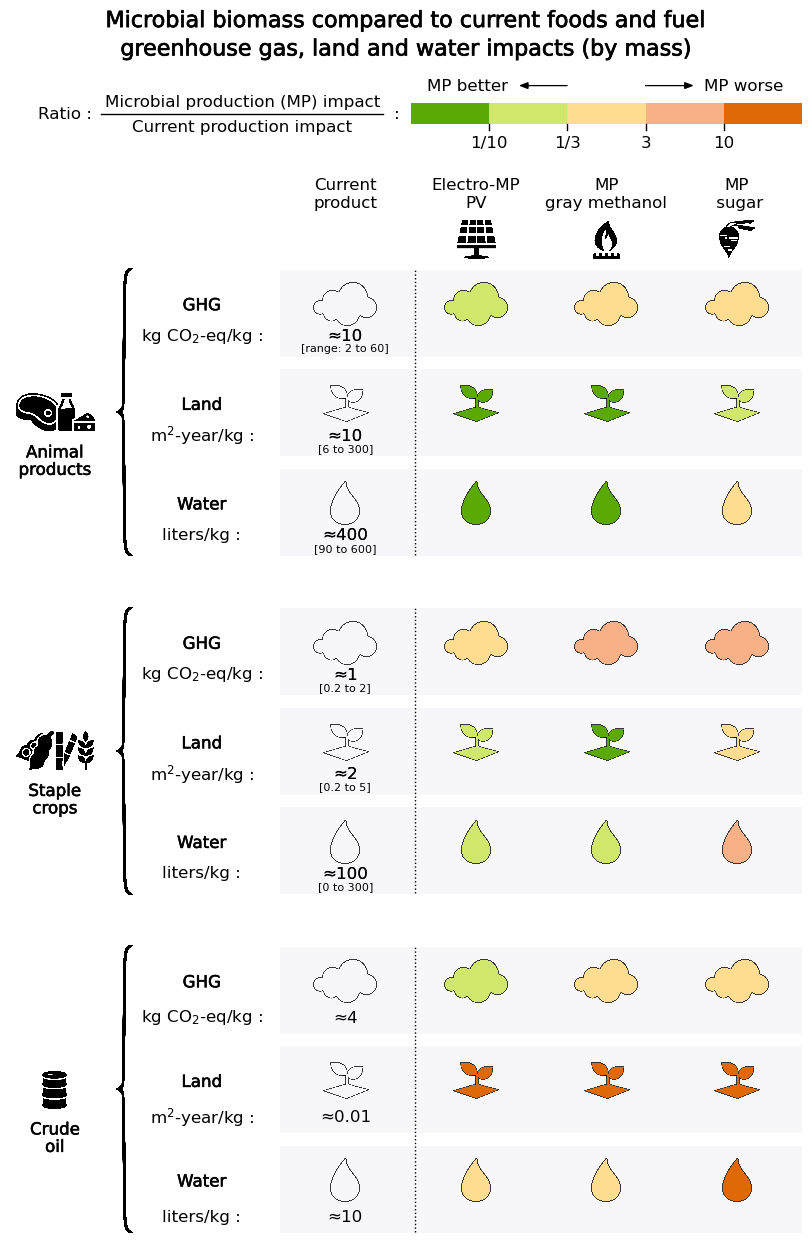

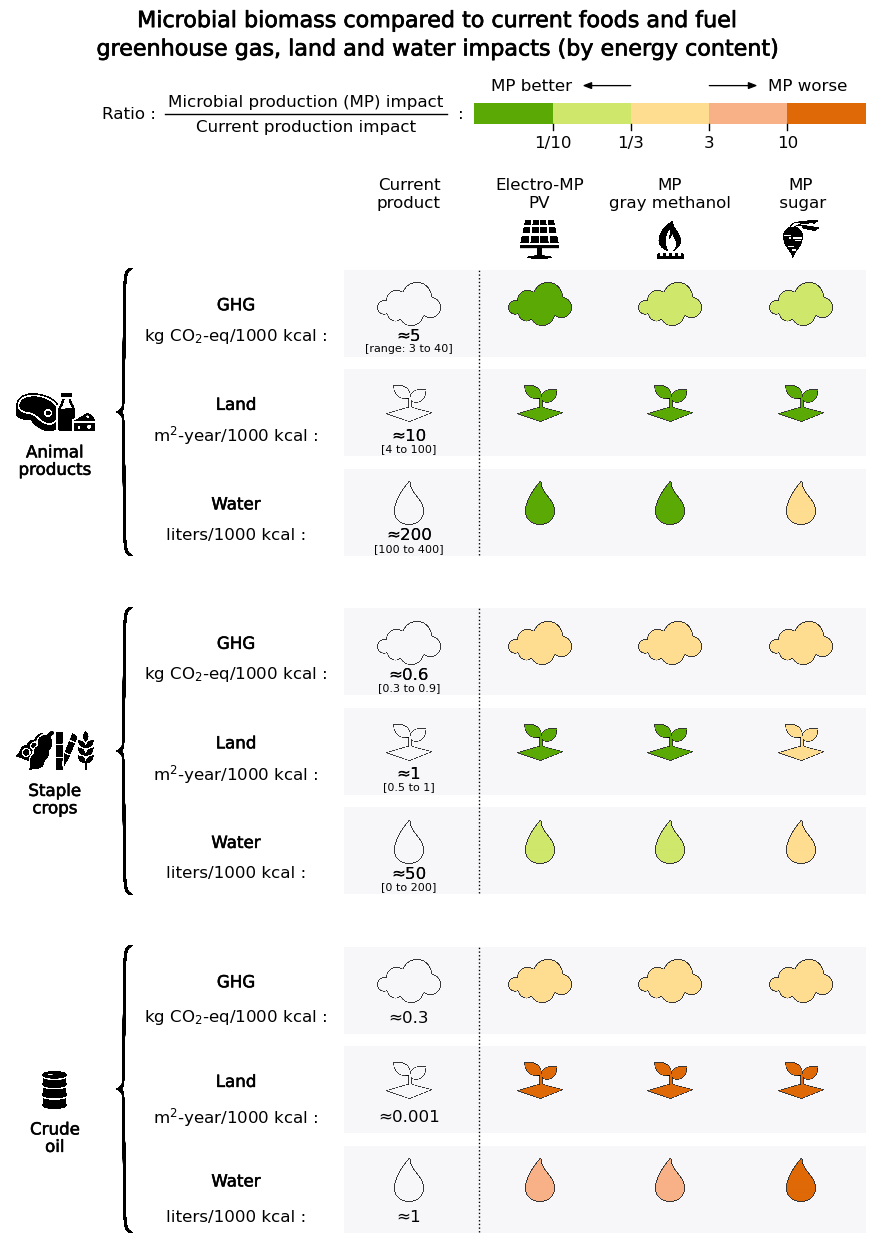

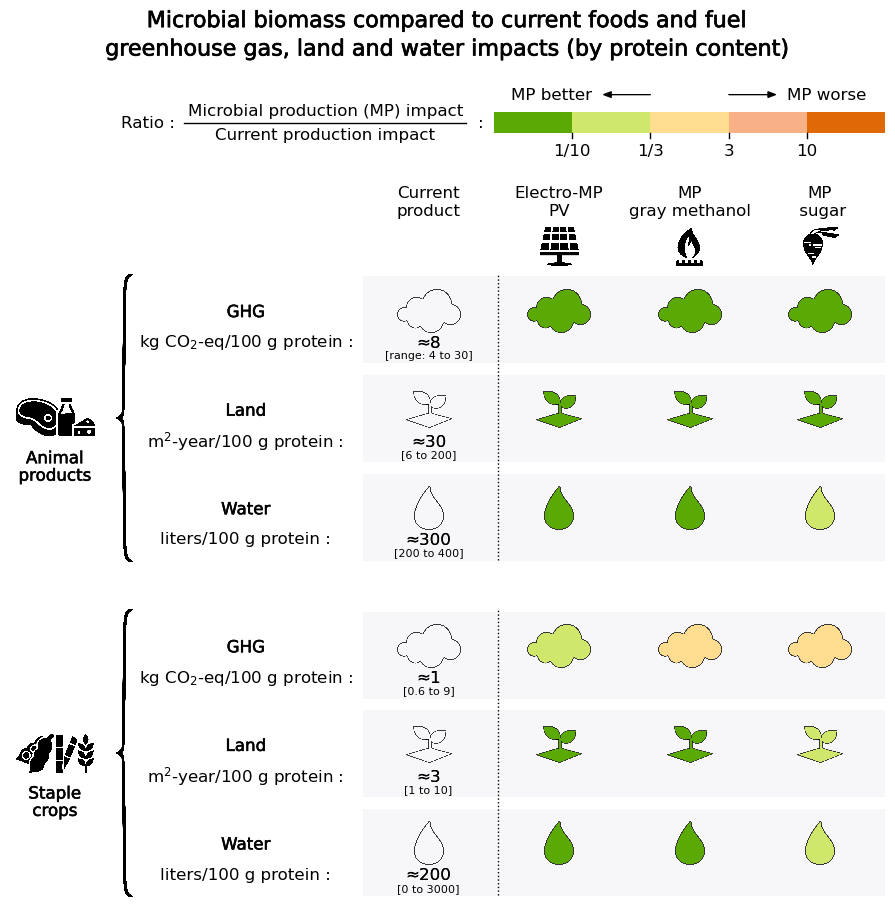

In [73]:
# plot the figure for different product units
# the figure is a grid based structure corresponding to a table 
# filled with different elements showing the ratio
# of microbial production compared to current products 
# across different prodcut categories and environmental impact categories,
# with annotations to the figure

for product_unit in ['kg', 'calories', 'protein']:

    # set the ordering product value categories, so there is consistent ordering within item groupings 
    # this makes it possible to call caloric content and protein content values according to their 
    # position in the item group after grouping
    env_impact_products = env_impact_products.sort_values('product_value_category').reset_index(drop=True)
    
    # for protein and caloric content, recalculate the environmental footprint of each product 
    # using their energy and protein content values
    # values are already given as imapct per kg, so no need to change base values for mass approach
    # then adjust figure parameters for each functional unit
    if product_unit == 'calories':
        env_impact_products_data_plot = calc_value_different_nutrition_unit(
            df=env_impact_products, 
            nutrition_content_idx=idx_caloric_content,  
            amount_nutrition=amount_calories   # footprint calculated for x kcal of product
        )
        # functional unit name
        product_unit_annot = f'{amount_calories} kcal'
        # x position of where to place the title of the row (manually determined)
        row_title_x_pos = -0.1
        # x loc of brace icon in first column (manually determined)
        brace_pad = -1.15
        # number of rows to plot
        # have 3 by 3 comparisons (3 products and 3 environmental impact categories - 9), 
        # want a row at top for colour bar, 
        # row for titles and icons 
        # and rows between impacts for spacing (2 between 3 groups)
        nrows = 9 + 4 
        # total size of figure in y dimension (manually determined) 
        y_fig_size = 15
        # ratio of the different row heights in the subplots (manually determined)
        height_ratios = [1.2,0.6,1,1,1,0.4,1,1,1,0.4,1,1,1]
        # which item groupings to include in the comparison to microbial products
        # for caloric content, compare all products to microbes
        food_cats = ['animal_products', 'staple_crops', 'crude_oil']
        # name to give the chemical property unit of the figure in the title e.g. impacts on a caloric basis
        title_chemical_property = 'energy content'
        # location of figure title (manually determined)
        title_y_pos = 0.93
        title_x_pos = 0.365
        
    if product_unit == 'protein':
        # crude oil has a protein content of 0, so it is excluded from comparisons on a protein basis
        env_impact_products_data_plot = env_impact_products[
            ~env_impact_products['new_name'].isin(['crude_oil'])
        ]
        env_impact_products_data_plot = calc_value_different_nutrition_unit(
            df=env_impact_products_data_plot, 
            nutrition_content_idx=idx_protein_content, 
            amount_nutrition=amount_protein   # footprint calculated for x grams of protein
        )
        product_unit_annot = f'{amount_protein} g protein'
        row_title_x_pos = -0.2
        brace_pad = -1.25
        # have 2 by 3 comparisons (2 products (rather than 3 as crude oil is excluded) 
        # and 3 environmental impact categories - 6), 
        # want a row at top for colour bar, 
        # row for titles and icons
        # and rows between impacts for spacing (1 between 2 groups)
        nrows = 6 + 3   
        y_fig_size = 10.5
        height_ratios = [1.2,0.6,1,1,1,0.4,1,1,1]
        food_cats = ['animal_products', 'staple_crops']
        title_x_pos = 0.3525
        title_chemical_property = 'protein content'
        title_y_pos = 0.96
        
    elif product_unit == 'kg': 
        # data is by default given on a per kg basis, so no processing of data needed
        env_impact_products_data_plot = env_impact_products
        product_unit_annot = 'kg'
        row_title_x_pos = 0.2
        brace_pad = -0.8
        # 3 by 3 comparisons - same as caloric
        nrows = 9 + 4 
        y_fig_size = 15
        height_ratios = [1.2,0.6,1,1,1,0.4,1,1,1,0.4,1,1,1]
        food_cats = ['animal_products', 'staple_crops', 'crude_oil']
        title_x_pos = 0.405
        title_chemical_property = 'mass'
        title_y_pos = 0.93
    
    # Num columns: 3 MP scenarios, 1 current product for comparison, 1 for impact category labelling
    ncols = 5  
    # create figure subplots
    fig, ax = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(8, y_fig_size), 
        dpi=100,
        gridspec_kw={'width_ratios': [0.75, 1, 1, 1, 1], 'height_ratios': height_ratios}
    )
    
    # Create a new axes that spans the top row to plot a color bar there
    gs = ax[0, 0].get_gridspec()
    # Create a new axes - this is where the colour bar will go
    # put color bar only over MP datas
    ax_top = fig.add_subplot(gs[0, 2:])
    
    # add icon for MP scenario at top of column 
    # no icon for current product 
    for col, icon in ((2,'mp_solar'), (3, 'mp_ng'), (4, 'mp_beet')):
        ax[1, col].set_aspect('equal', adjustable='box')
        arr_img = plt.imread(f"{icon}.png")
        im = OffsetImage(arr_img, zoom=.025)
        ab = AnnotationBbox(
            im, (0.5, 0.2), 
            xycoords='data', 
            box_alignment=(0.5,0.2), 
            frameon=False, 
            annotation_clip=False
        )
        ax[1, col].add_artist(ab)

    # plot the comparison data for the different product categories 
    # and different environmental impact categories
    row_num = 2
    for item in food_cats:
        col_num = 1  # the first column is used for the product icons
        for impact, row_title, unit, icon in (
            ('ghg', 'GHG', f'kg CO$_2$-eq/{product_unit_annot}', 'ghg_emissions'),
            ('land', 'Land', f'm$^2$-year/{product_unit_annot}', 'land_use'),
            ('blue_water', 'Water', f'liters/{product_unit_annot}', 'water_use'),
        ): 
            # an extra row is added between GHG and land use and land use and water consumption
            # to make it easy to see that comparing across a row and different rows correspond
            # to different thigns
            if row_num == 5 or row_num == 9: 
                row_num += 1 
            col_num = 0

            # make the axes equal in aspect size (squares) - this helps to avoid unusual aspect 
            # ratios, but means a change in the x or y limits alters the other too 
            ax[row_num, col_num].set_aspect('equal', adjustable='box')
            
            # add icons showing product categories in the first column
            # and annotate accordingly
            if row_num in [3,7,11]:
                arr_img = plt.imread(f"{item}.png")
                im = OffsetImage(arr_img, zoom=.025)
                ab = AnnotationBbox(
                    im, (row_title_x_pos+brace_pad-0.7, 0.5), 
                    xycoords='axes fraction', 
                    frameon=False, 
                    annotation_clip=False
                )
                ax[row_num, 0].add_artist(ab)
        
                text = ax[row_num, 0].annotate(
                    text="\n".join(
                        wrap(item.replace('_', ' '), 7, break_long_words=False)
                    ).capitalize(), 
                    xy=(row_title_x_pos+brace_pad-0.7, 0),
                    xytext=(row_title_x_pos+brace_pad-0.7, 0), va='center',
                    ha='center',fontsize=12, annotation_clip=False          
                )
                text.set_path_effects([withStroke(linewidth=0.4, foreground='black')])
            
            # add brace to show which rows correspond to the product category
            if row_num in [3,7,11]:
                arr_img = plt.imread('curly_brace_upright.png')
                im = OffsetImage(arr_img, zoom=.025)
                ab = AnnotationBbox(
                    im, (row_title_x_pos+brace_pad, 0.5), 
                    xycoords='axes fraction', 
                    frameon=False, 
                    annotation_clip=False
                )
                ax[row_num, 0].add_artist(ab)
            
            # add row label showing the environmental impact category e.g. GHG emissions
            text = ax[row_num, 0].annotate(
                text=row_title, 
                xy=(row_title_x_pos, 0.575),
                xytext=(row_title_x_pos, 0.575), va='center',
                ha='center',fontsize=12, annotation_clip=False          
            )
            text.set_path_effects([withStroke(linewidth=0.4, foreground='black')])

            # add unit below the row label e.g. kgCO2eq/kg product
            if item == 'crude_oil': 
                value_y_annot_pos = 0.225
            else: 
                value_y_annot_pos = 0.275
            ax[row_num, 0].annotate(
                text=f"{unit} :", 
                xy=(row_title_x_pos, value_y_annot_pos),
                xytext=(row_title_x_pos, value_y_annot_pos), va='center',
                ha='center',fontsize=12, annotation_clip=False          
            )
            
            # calculate the median and range for the different product categories
            # note, fuels consists solely of crude oil 
            if item == 'crude_oil':
                item_cat = 'fuel'
            else: 
                item_cat = item
            current_value = env_impact_products_data_plot[
                (env_impact_products_data_plot['food_category'] == item_cat) & 
                (env_impact_products_data_plot['product_value_category'] == impact)
            ]['value'].median()
            current_value_min = env_impact_products_data_plot[
                (env_impact_products_data_plot['food_category'] == item_cat) & 
                (env_impact_products_data_plot['product_value_category'] == impact)
            ]['value'].min()
            current_value_max = env_impact_products_data_plot[
                (env_impact_products_data_plot['food_category'] == item_cat) & 
                (env_impact_products_data_plot['product_value_category'] == impact)
                & (env_impact_products_data_plot['value'] != np.inf)
            ]['value'].max()

            # icons illustrating environmental category being considered in the given row
            # becuase here it is just comparing current to current (first column) 
            # the icon is not filled
            add_and_recolor_icon(icon, row_num, 1, ratio_mp_to_current=1)
            
            # add median footprint value and range below icon for current product
            # round the values to one signficant figure
            if current_value >= 10 or current_value < 1:
                rounded_val = round_to_n(current_value, 1)
            elif current_value < 10 and current_value >= 1:
                rounded_val = round(current_value, 0)
            if rounded_val >= 1:
                rounded_val = int(rounded_val)
    
            if current_value_min >= 10 or current_value_min < 1:
                rounded_val_min = round_to_n(current_value_min, 1)
            elif current_value_min < 10 and current_value_min >= 1:
                rounded_val_min = round(current_value_min, 0)
            if rounded_val_min >= 1:
                rounded_val_min = int(rounded_val_min)
    
            if current_value_max >= 10 or current_value_max < 1:
                rounded_val_max = round_to_n(current_value_max, 1)
            elif current_value_max < 10 and current_value_max >= 1:
                rounded_val_max = round(current_value_max, 0)
            if rounded_val_max >= 1:
                rounded_val_max = int(rounded_val_max)

            # given their large ranges, animal product ghg emissions and staple crop water use
            # values are rounded to an order of magnitude to reflect the uncertainty
            # of giving a point value for data spanning > 2 orders of magnitude
            if (
                (item == 'animal_products' and impact == 'ghg' and product_unit == 'kg') 
                or (item == 'staple_crops' and impact == 'blue_water' and product_unit == 'kg')
            ):
                rounded_val = round_to_n(rounded_val, 0)
    
            # staple crops and animal products correspond to groups of items 
            # so the median and range is reported, whereas fuels just 
            # corresponds to crude oil, so a range is not given for this 
            # as it is just one item
            if item in ['staple_crops', 'animal_products']:
                if row_num == 2: 
                    # annotate the first appearance, making clear it is a range
                    text = f'[range: {rounded_val_min} to {rounded_val_max}]'
                else: 
                    text = f'[{rounded_val_min} to {rounded_val_max}]'
                
                ax[row_num, 1].annotate(
                    text=text, 
                    xy=(0.5, 0.15),
                    xytext=(0.5, 0.15), 
                    va='top', ha='center', fontsize=8,
                    annotation_clip=False
                )
                value_y_annot_pos = 0.325
                ax[row_num, 1].annotate(
                    text=f'≈{rounded_val}', 
                    xy=(0.5, value_y_annot_pos),
                    xytext=(0.5, value_y_annot_pos), 
                    va='top', ha='center', fontsize=12,
                    annotation_clip=False
                )
            else: 
                value_y_annot_pos = 0.275

            # add median value for all product categories (including fuels)
            ax[row_num, 1].annotate(
                text=f'≈{rounded_val}', 
                xy=(0.5, value_y_annot_pos),
                xytext=(0.5, value_y_annot_pos), 
                va='top', ha='center', fontsize=12,
                annotation_clip=False
            )
            


            # add in icons for microbial production and fill the icons with the color
            # corresponding to their ratio with the current product of interest
            col_num = 2
            for mp in ['mp_pv', 'mp_gray_methanol', 'mp_sugar']: 
                mp_value = env_impact_products_data_plot[
                    (env_impact_products_data_plot['product_value_category'] == impact)
                    & (env_impact_products_data_plot['new_name'] == mp) 
                ]['value'].values[0]
                
                ratio_mp_to_current = mp_value / current_value
                
                add_and_recolor_icon(icon, row_num, col_num, ratio_mp_to_current=ratio_mp_to_current)
    
                # don't include annotations of the values used for microbial products
                # as there is large uncertainty, which cannot be appreciated by just glancing 
                # at the figure, to avoid misuse/confusion, 
                # these values are not given in the figure, but
                # can be found in Supplementary Table S2 of the manuscript files
    
                # repeat the process for the next microbial production scenario in the adjacent column
                col_num +=1
            
            # add shading to the axes to make clear that 
            # comparing across the row
            for col in [1,2,3,4]:
                ax[row_num, col].set_facecolor('#F7F7F9')
                ax[row_num, col].add_artist(ax[row_num, col].patch)
                ax[row_num, col].patch.set_zorder(-1)
                ax[row_num, col].set_xlim(-0.25, 1.25)

            # repeat the process for the next environmental impact category in the row below
            row_num += 1

    # add in column labels
    col_title_y_pos = 1.3
    ax[1, 1].set_title('Current\nproduct',y=col_title_y_pos, fontsize=12, va='top')
    ax[1, 2].set_title('Electro-MP\nPV',y=col_title_y_pos, fontsize=12,va='top')
    ax[1, 3].set_title('MP\ngray methanol', y=col_title_y_pos, fontsize=12, va='top')
    ax[1, 4].set_title('MP\n sugar', y=col_title_y_pos, fontsize=12, va='top')
     

    # add vertical line to distinguish current from the rest
    # to make sure it can overlap the adjacent axis, 
    # set the zorder of the axis plotted on as higher
    if product_unit == 'protein': 
        rows_to_add_line = [4, 8]
    else: 
        rows_to_add_line = [4, 8, 12]
    for row in rows_to_add_line:
        ax[row, 1].set_zorder(ax[row-1, 1].get_zorder()+1)
        ax[row, 1].plot(
            [1.3, 1.3], 
            [0.01, 3.3],
            color='k', 
            linestyle='dotted', 
            lw=1, 
            clip_on=False, 
            zorder=100
        )
        ax[row, 1].set_xlim(-0.25, 1.25)
        ax[row, 1].set_ylim(0, 1)
    
    
    # create a custom color bar on the top axis using patches
    ax_top.set_xlim(0,1)    
    ax_top.set_ylim(0,1) 

    # specify the colours of the patches according to the colours used as the ratios of 
    # current to microbial production
    cb_patch_num = 0
    cb_patch_colors = [
        v_low_impact_thresh_color, low_impact_thresh_color, 
        similar_color, high_impact_thresh_color,
        v_high_impact_thresh_color
    ]

    # define the height and width of the patches in the colour bar 
    # according to the length of the axis plotted on (fill up the axis in the x direction)
    color_bar_patch_width = 1 / len(cb_patch_colors)
    color_bar_patch_height = 0.175

    # values determining the thresholds for changing colour 
    cb_patch_labels = [
        f'{str(Fraction(Fraction(v_low_impact_thresh).limit_denominator(1_000_000)))}',
        f'{str(Fraction(Fraction(low_impact_thresh).limit_denominator(1_000_000)))}', 
        f'{Fraction(high_impact_thresh)}',
        f'{Fraction(v_high_impact_thresh)}'
    ]
    
    cb_patch_y_pos = 0.75 - color_bar_patch_height/2  # y position to plot color bar, 
    # the patch is plotted from the central y position too, so expand outwards from there
    cb_x_mid = (ax_top.get_xlim()[1]-ax_top.get_xlim()[0])/2  # plot from center (x) of axis
    cb_start_x_pos = cb_x_mid-len(cb_patch_colors)*color_bar_patch_width/2
    
    # draw a patch for each environmental impact ratio color to create a color bar
    for num, color in enumerate(cb_patch_colors): 
        # plot each patch next to each other
        # calculate position based on center of x axis (x width is 1)
        # width of color bar is the patch widths * number of patches
        # starting point is half the width as define start relative to center of plot
        cb_patch_x_pos = cb_start_x_pos + cb_patch_num * color_bar_patch_width
        
        rect = Rectangle(
            (cb_patch_x_pos, cb_patch_y_pos), 
            color_bar_patch_width, color_bar_patch_height,
            facecolor=color,
            ec=None
        )
        ax_top.add_patch(rect)

        # add the threshold values for different colours below the colour bar as xticks 
        if num < len(cb_patch_labels):
            ax_top.annotate(
                text=cb_patch_labels[num], 
                xy=(cb_patch_x_pos+color_bar_patch_width, cb_patch_y_pos-color_bar_patch_height/2),
                xytext=(cb_patch_x_pos+color_bar_patch_width, cb_patch_y_pos-color_bar_patch_height/2), 
                va='top', ha='center', fontsize=12,
                annotation_clip=False
            )
            # add ticks to marks
            ax_top.plot(
                [cb_patch_x_pos+color_bar_patch_width, cb_patch_x_pos+color_bar_patch_width],
                [cb_patch_y_pos, cb_patch_y_pos-color_bar_patch_height/4],
                color='k',
                lw=1
            )
        cb_patch_num += 1
    
    # add in annotation for color bar - the ratio of MP to current  
    ratio_text_y_pad = 0.04 
    annotation_y = 0.95
    annotation_x = -0.43
    ax_top.annotate(
        text='Microbial production (MP) impact', 
        xy=(annotation_x, cb_patch_y_pos+ratio_text_y_pad+color_bar_patch_height/2),
        xytext=(annotation_x, cb_patch_y_pos+ratio_text_y_pad+color_bar_patch_height/2), 
        va='bottom', ha='center', fontsize=12,
        annotation_clip=False
    )
    # division line
    divisor_half_width = 0.36
    ax_top.plot(
        [annotation_x-divisor_half_width, annotation_x+divisor_half_width], 
        [cb_patch_y_pos+color_bar_patch_height/2, cb_patch_y_pos+color_bar_patch_height/2],
        clip_on=False,
        color='k', lw=1
    )
    ax_top.annotate(
        text=':', 
        xy=(annotation_x+divisor_half_width*1.1, cb_patch_y_pos+color_bar_patch_height/2),
        xytext=(annotation_x+divisor_half_width*1.1, cb_patch_y_pos+color_bar_patch_height/2), 
        va='center', ha='center', fontsize=12,
        annotation_clip=False
    )
    ax_top.annotate(
        text='Current production impact', 
        xy=(annotation_x, cb_patch_y_pos-ratio_text_y_pad+color_bar_patch_height/2),
        xytext=(annotation_x, cb_patch_y_pos-ratio_text_y_pad+color_bar_patch_height/2), 
        va='top', ha='center', fontsize=12,
        annotation_clip=False
    )
    ax_top.annotate(
        text='Ratio : ', 
        xy=(annotation_x-divisor_half_width-0.01, cb_patch_y_pos+color_bar_patch_height/2),
        xytext=(annotation_x-divisor_half_width-0.01, cb_patch_y_pos+color_bar_patch_height/2), 
        va='center', ha='right', fontsize=12,
        annotation_clip=False
    )

    # add in annotation showing greener is better and redder is worse
    cb_annotation_y_pos = cb_patch_y_pos + 0.325
    ax_top.arrow(
        x=cb_x_mid-color_bar_patch_width*0.5, y=cb_annotation_y_pos, 
        dx=-color_bar_patch_width*0.5, dy=0, 
        color='k', lw=0.8,
        head_width=0.05, head_length=color_bar_patch_width/10,
        clip_on=False
    )
    ax_top.arrow(
        x=cb_x_mid+color_bar_patch_width*0.5, y=cb_annotation_y_pos, 
        dx=color_bar_patch_width*0.5, dy=0, 
        color='k', lw=0.8,
        head_width=0.05, head_length=color_bar_patch_width/10,
        clip_on=False
    )
    ax_top.annotate(
        text='MP worse', 
        xy=(cb_x_mid+color_bar_patch_width*1.25, cb_annotation_y_pos),
        xytext=(cb_x_mid+color_bar_patch_width*1.25, cb_annotation_y_pos), 
        va='center', ha='left', fontsize=12,
        annotation_clip=False
    )
    ax_top.annotate(
        text='MP better', 
        xy=(cb_x_mid-color_bar_patch_width*1.25, cb_annotation_y_pos),
        xytext=(cb_x_mid-color_bar_patch_width*1.25, cb_annotation_y_pos), 
        va='center', ha='right', fontsize=12,
        annotation_clip=False
    )

    # turn off all aces to remove border and ticks to remove the underlying grid structure
    for axis in ax.ravel():
        axis.set_axis_off()
        axis.set_aspect('equal', adjustable='box')
    ax_top.axis('off')    

    # reduce spacing between axes so axes touch in the x dimension
    # to make grey panelling behind rows continuous to show 
    # comparison across the row
    # note, the x is longer than the y direction, so the axes won't touch in the y 
    # direction
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # add overall title to figure
    text = fig.suptitle(
        f'Microbial biomass compared to current foods and fuel\ngreenhouse gas, land and water impacts (by {title_chemical_property})', 
        x=title_x_pos, y=title_y_pos, fontsize=16, ha='center', linespacing=1.3
    )
    text.set_path_effects([withStroke(linewidth=0.5, foreground='black')])

    # save figures in both png and svg format
    plt.show()
    fig.savefig(f'summary_env_implications_microbial_production_{product_unit}.svg', bbox_inches='tight')
    fig.savefig(f'summary_env_implications_microbial_production_{product_unit}.png', bbox_inches='tight')